In [1]:
using JLD2
using FourierFlows
using FourierFlows: parsevalsum2, parsevalsum
using Printf
using CairoMakie
using AbstractFFTs
include("../../utils/IFMAB3.jl")
include("../../swqg/TwoLayerQG.jl")
include("AnalysisUtils.jl")
using .TwoLayerQG

In [2]:
run_directory = "/scratch/nad9961/twolayer_rays/60112234/"
Nsnapshots = count_key_snapshots(run_directory, "2Lqg")

6708

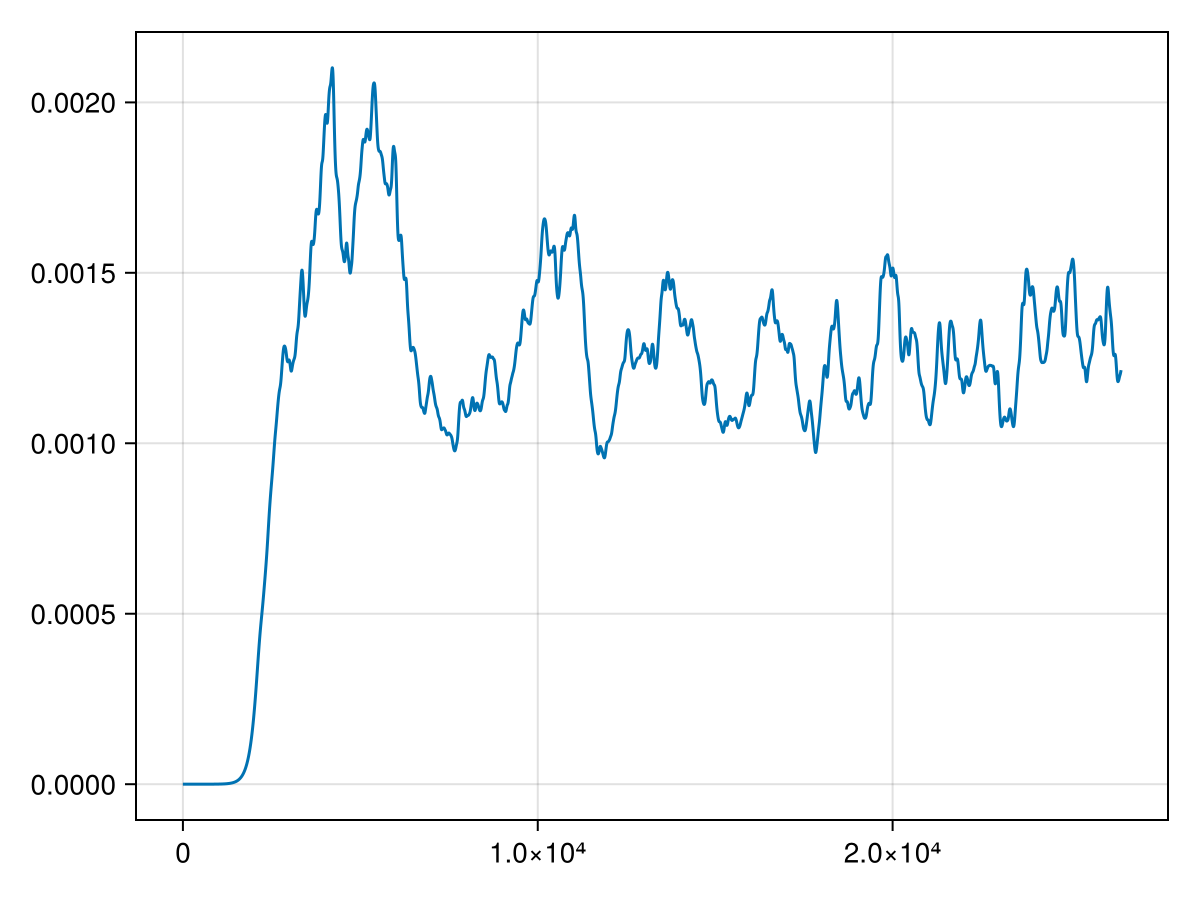

In [3]:
diagnostics = jldopen(run_directory * "diagnostics.jld2")
diag_t = diagnostics["diagnostics/kinetic_energy/t"]
KE = diagnostics["diagnostics/kinetic_energy/data"]
KE1 = map(x->x[1], KE)
KE2 = map(x->x[2], KE)
PE = diagnostics["diagnostics/potential_energy/data"]
close(diagnostics)
lines(diag_t, KE1 + KE2 + 2*PE)

In [4]:
idx1 = 22300
idx2 = 21002


21002

In [5]:
t, qh = load_key_snapshot(run_directory, "2Lqg", Nsnapshots)

(26437.168f0, ComplexF32[-8.128372f0 + 0.0f0im -1350.497f0 + 63.5028f0im … 1446.325f0 + 2071.0076f0im -1350.4954f0 - 63.50448f0im; -1345.2972f0 - 1750.0336f0im 974.07764f0 + 2408.8943f0im … -2540.2505f0 - 922.4593f0im 2528.7913f0 + 1937.1796f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 0.69844747f0 + 0.0f0im 1108.7098f0 - 415.0145f0im … -2409.16f0 - 1161.2649f0im 1108.7084f0 + 415.016f0im; 1085.4471f0 + 1810.4386f0im -654.72296f0 - 2575.8977f0im … 1272.8337f0 + 818.2555f0im -1545.3877f0 - 1948.9174f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im])

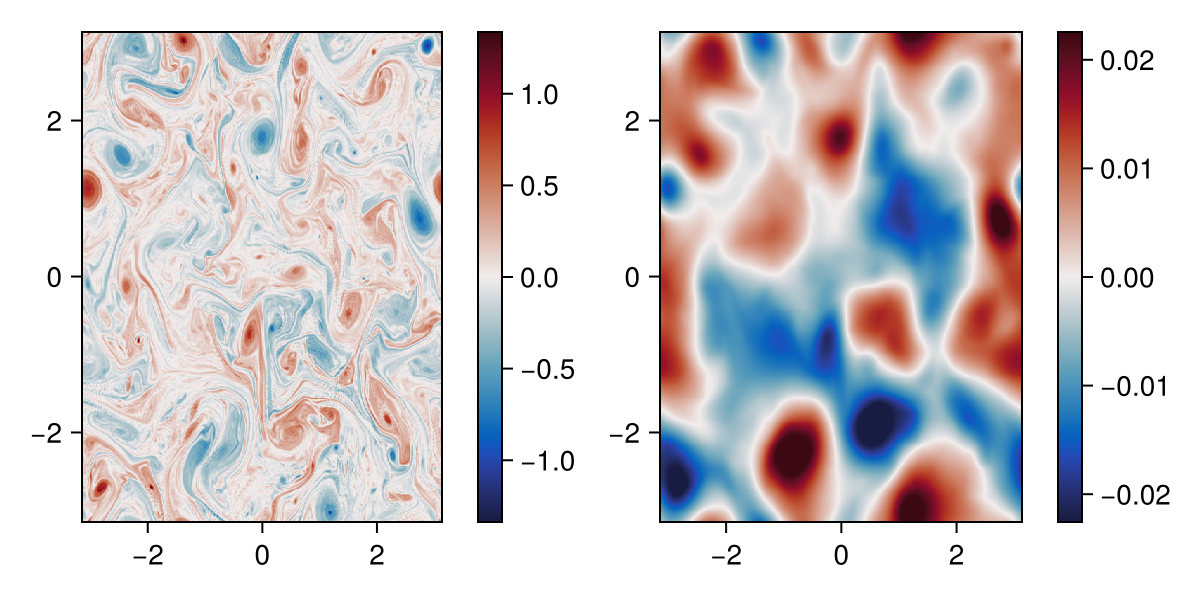

In [21]:
nx = size(qh, 2)
grid = TwoDGrid(; nx=nx, Lx=2π)
params = read_2Lqg_params(run_directory)
F = params.F
ν, nν = read_dissipation(run_directory, "2Lqg")

ψh = similar(qh)
TwoLayerQG.streamfunctionfrompv!(ψh, qh, grid, params)

uh = @. -1im * grid.l  * ψh
vh = @.  1im * grid.kr * ψh

uxh = @. 1im * grid.kr * uh
vxh = @. 1im * grid.kr * vh
uyh = @. 1im * grid.l  * uh
vyh = @. 1im * grid.l  * vh

q = irfft(qh, grid.nx, (1,2))
ψ = irfft(ψh, grid.nx, (1,2))

u = irfft(uh, grid.nx, (1,2))
v = irfft(vh, grid.nx, (1,2))
ux = irfft(uxh, grid.nx, (1,2))
vx = irfft(vxh, grid.nx, (1,2))
uy = irfft(uyh, grid.nx, (1,2))
vy = irfft(vyh, grid.nx, (1,2))


fig = Figure(size=(600, 300))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,3])
q_max = maximum(abs.(q))
ψ_max = maximum(abs.(ψ))
hm1 = heatmap!(ax1, grid.x, grid.y, q[:,:,1] + q[:,:,2]; colormap=:balance, colorrange=(-q_max, q_max))
cbar1 = Colorbar(fig[1,2], hm1)
hm2 = heatmap!(ax2, grid.x, grid.y, ψ[:,:,1] + ψ[:,:,2]; colormap=:balance, colorrange=(-ψ_max, ψ_max))
cbar2 = Colorbar(fig[1,4], hm2)

fig

In [73]:
run_directory = "/scratch/nad9961/twolayer_rays/60112234/"
Nsnapshots = count_key_snapshots(run_directory, "2Lqg")

println(Nsnapshots)
grid = TwoDGrid(; nx=512, Lx=2π)

params = read_2Lqg_params(run_directory)
F = params.F
U = params.U
μ = params.μ
ν, nν = read_dissipation(run_directory, "2Lqg")

Rh = zeros(grid.nkr, grid.nl)
snap_frames = (Nsnapshots-4000):Nsnapshots
total_E = zeros(length(snap_frames))
array_idx = 1

for snap_idx = snap_frames
    if (snap_idx % 10 == 0)
        println(snap_idx)
    end
    t, qh = load_key_snapshot(run_directory, "2Lqg", snap_idx)
   
    ψh = similar(qh)
    TwoLayerQG.streamfunctionfrompv!(ψh, qh, grid, params)
    
    uh = @. -1im * grid.l  * ψh
    vh = @.  1im * grid.kr * ψh
    
    qxh = @. 1im * grid.kr * qh
    qyh = @. 1im * grid.l  * qh
    
    q = irfft(qh, grid.nx, (1,2))
    ψ = irfft(ψh, grid.nx, (1,2))
    
    u = irfft(uh, grid.nx, (1,2))
    v = irfft(vh, grid.nx, (1,2))
    qx = irfft(qxh, grid.nx, (1,2))
    qy = irfft(qyh, grid.nx, (1,2))
    
    uqxh = rfft(u .* qx, (1,2))
    vqyh = rfft(v .* qy, (1,2))

    KE1 = @views 0.5 * (parsevalsum2(uh[:,:,1], grid) + parsevalsum2(vh[:,:,1], grid))
    KE2 = @views 0.5 * (parsevalsum2(uh[:,:,2], grid) + parsevalsum2(vh[:,:,2], grid))
    total_E[array_idx] = KE1 + KE2 + 0.5 * params.F * parsevalsum(abs2.(view(ψh, :, :, 1) .- view(ψh, :, :, 2)), grid)
    array_idx += 1

    nonlinear_terms = conj(ψh) .* (-uqxh - vqyh)
    ψh1 = @views ψh[:,:,1]
    ψh2 = @views ψh[:,:,2]
    qh1 = @views qh[:,:,1]
    qh2 = @views qh[:,:,2]

    PV_term = 2im * grid.kr * F * U 
    drag_term = μ*grid.Krsq
    U_term = 1im * grid.kr * U
    D = -ν * grid.Krsq.^(nν)
    
    linear_terms1 = conj(ψh1) .* (-PV_term .* ψh1 + D .* qh1 - U_term .* qh1)
    linear_terms2 = conj(ψh2) .* (PV_term .* ψh2 + drag_term .* ψh2 + D .* qh2 + U_term .* qh2)
    
    Eh = nonlinear_terms[:,:,1] + nonlinear_terms[:,:,2]# + linear_terms1 + linear_terms2
    Rh += real(Eh)
end

6708
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930
3940
3950
3960
3970
3980
3990
4000
4010
4020
4030
4040
4050
4060
4070
4080
4090
4100
4110
4120
4130
4140
4150
4160
4170
4180
4190
4200
4210
4220
4230
4240
4250
4260
4270
4280
4290
4300
4310
4320
4330
4340
4350
4360
4370
4380
4390
4400
4410
4420
4430
4440
4450
4460
4470
4480
4490
4500
4510
4520
4530
4540
4550
4560
4570
4580
4590
4600
4610
4620
4630
4640
4650
4660
4670
4680
4690


-0.016956215700598725


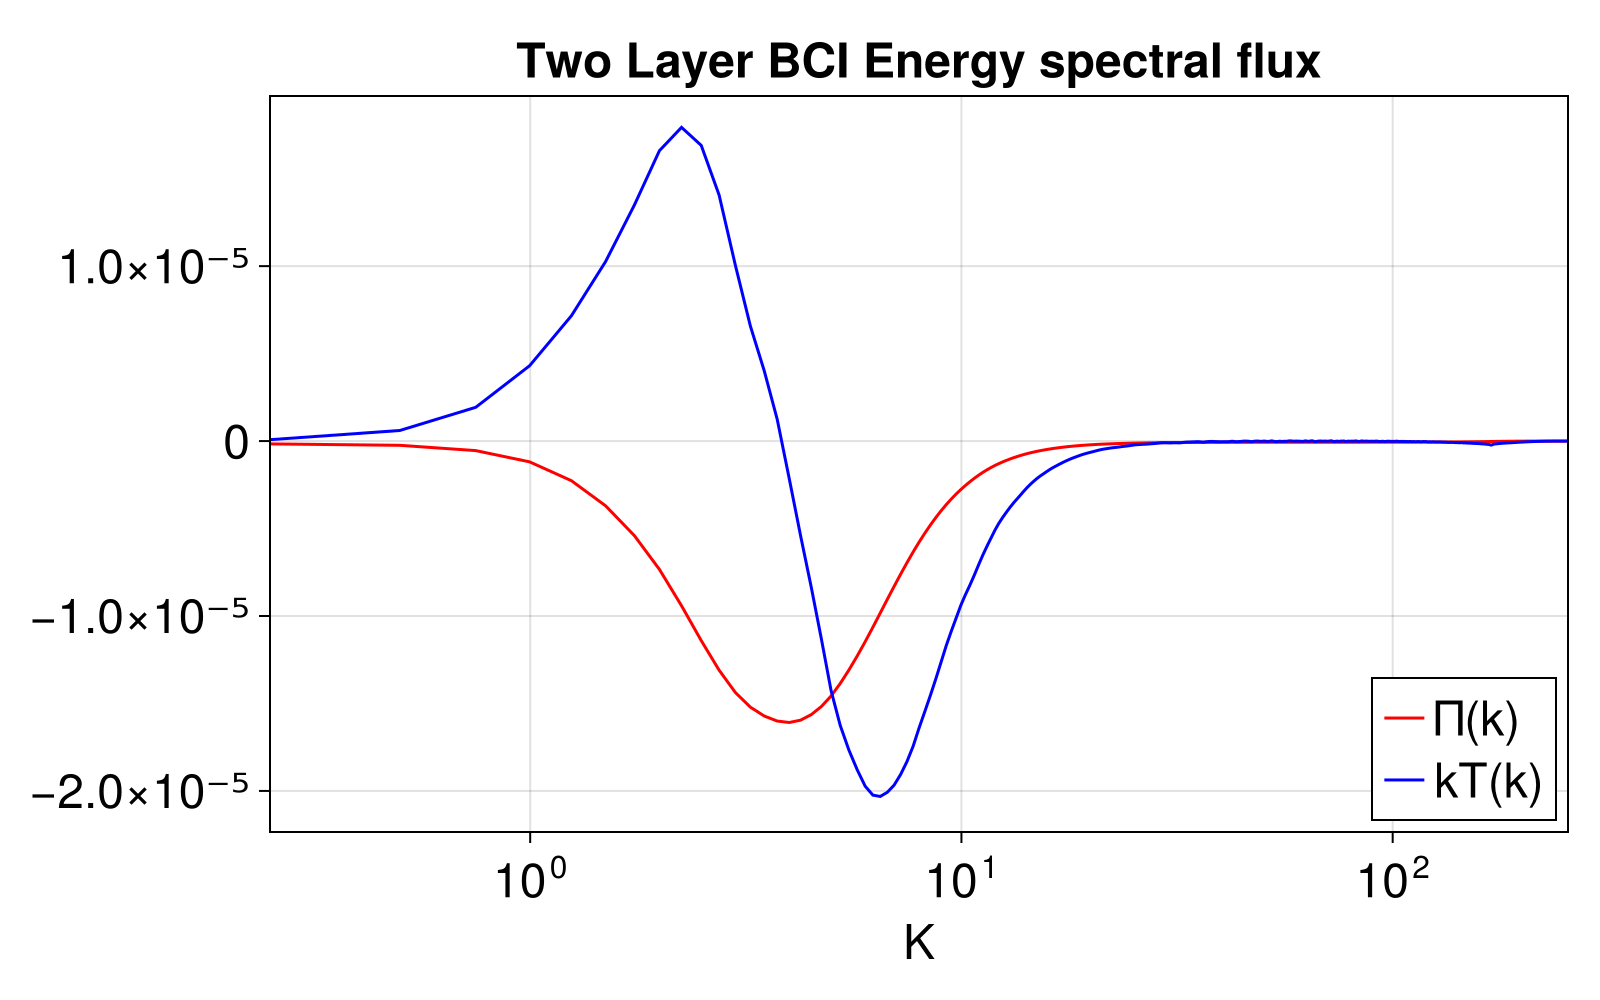

In [75]:
Rh_normed = Rh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
ρ, Rhr = FourierFlows.radialspectrum(Rh_normed / 4000, grid)
dρ = ρ[2] - ρ[1]
Rhr = Rhr[:]
Πh = cumsum((dρ * Rhr)[end:-1:1])[end:-1:1]
Πh2 = -cumsum(Rhr)
fig = Figure(size=(800, 500), fontsize=24)
ax = Axis(fig[1,1]; title = "Two Layer BCI Energy spectral flux", xlabel="K",
    xscale=log10, limits=((ρ[2], ρ[end]), (1.1*minimum(ρ.*Rhr), 1.1*maximum(ρ.*Rhr))))
println(sum(Rh_normed))
lines!(ax, ρ, Πh, color=:red, label="Π(k)")
lines!(ax, ρ, ρ.*Rhr, color=:blue, label="kT(k)")
#lines!(ax, ρ, Πh2, color=:green, label="Π(k)")
axislegend(ax, position=:rb)
fig

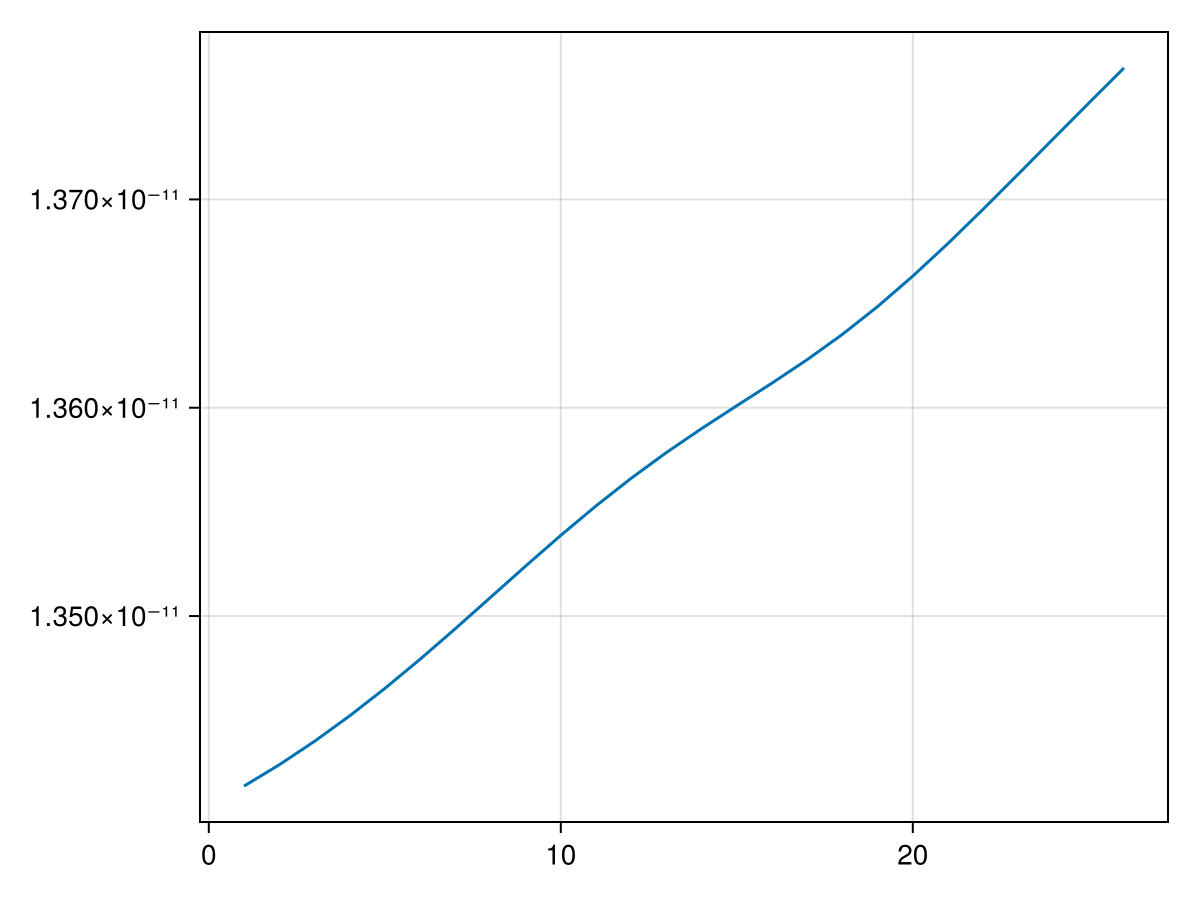

In [33]:
fig = Figure()
ax = Axis(fig[1,1])
lines((total_E) * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2))

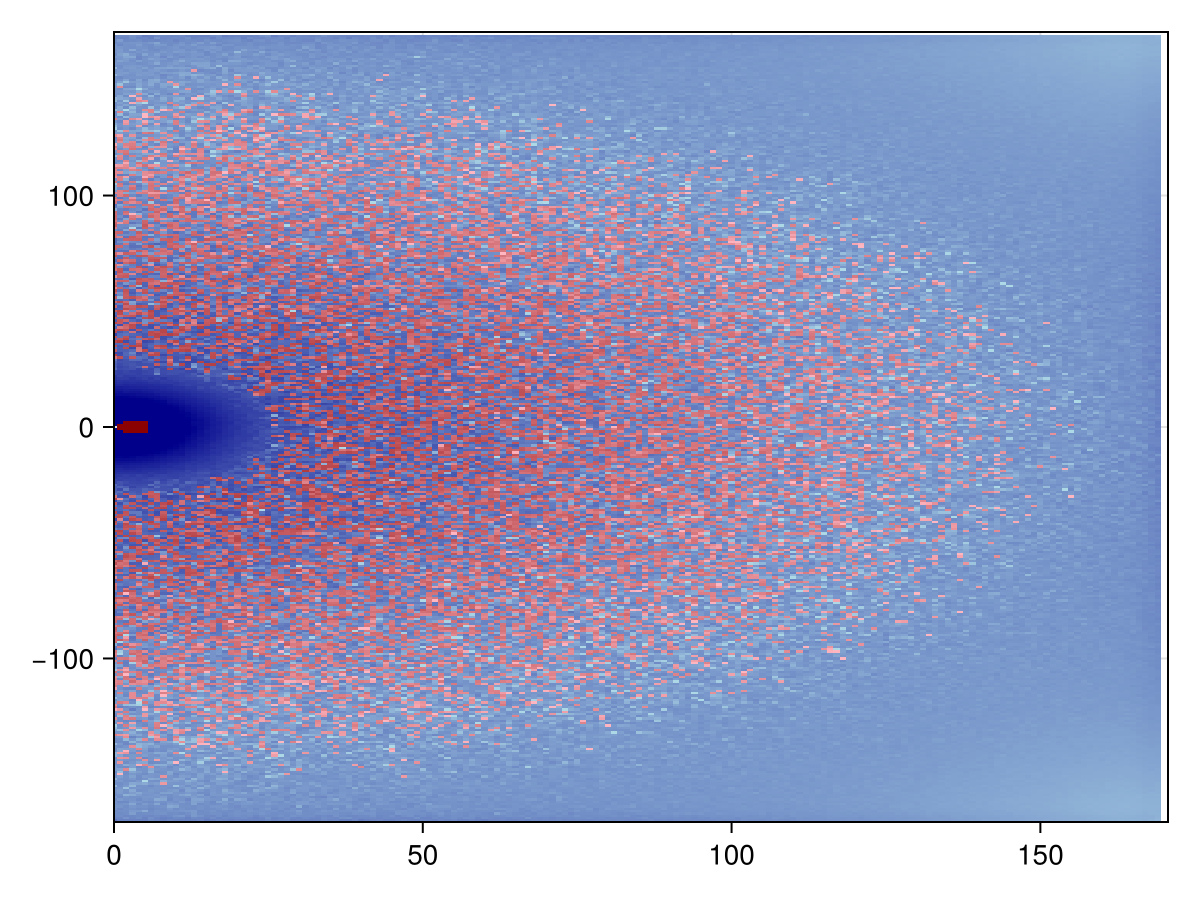

In [76]:
fig = Figure()

α = 1 - grid.aliased_fraction
ax = Axis(fig[1,1], limits=((grid.kr[1], α*grid.kr[end]), (-α*grid.kr[end], α*grid.kr[end])))
pos_Rh = deepcopy(Rh_normed)
neg_Rh = deepcopy(Rh_normed)
pos_Rh[pos_Rh .<= 0.0] .= 0
neg_Rh[neg_Rh .>= 0.0] .= 0 
heatmap!(ax, grid.kr[:], fftshift(grid.l[:]), fftshift(replace(log.( pos_Rh), -Inf=>NaN), 2), colormap=:reds, colorrange=(-23, -11))
heatmap!(ax, grid.kr[:], fftshift(grid.l[:]), fftshift(replace(log.(-neg_Rh), -Inf=>NaN), 2), colormap=:blues, colorrange=(-23, -11))

fig

1×512 Matrix{Float64}:
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  …  -6.0  -5.0  -4.0  -3.0  -2.0  -1.0

In [34]:
minimum(log.(max.(Rh_normed, 1e-10)))

-23.025850929940457

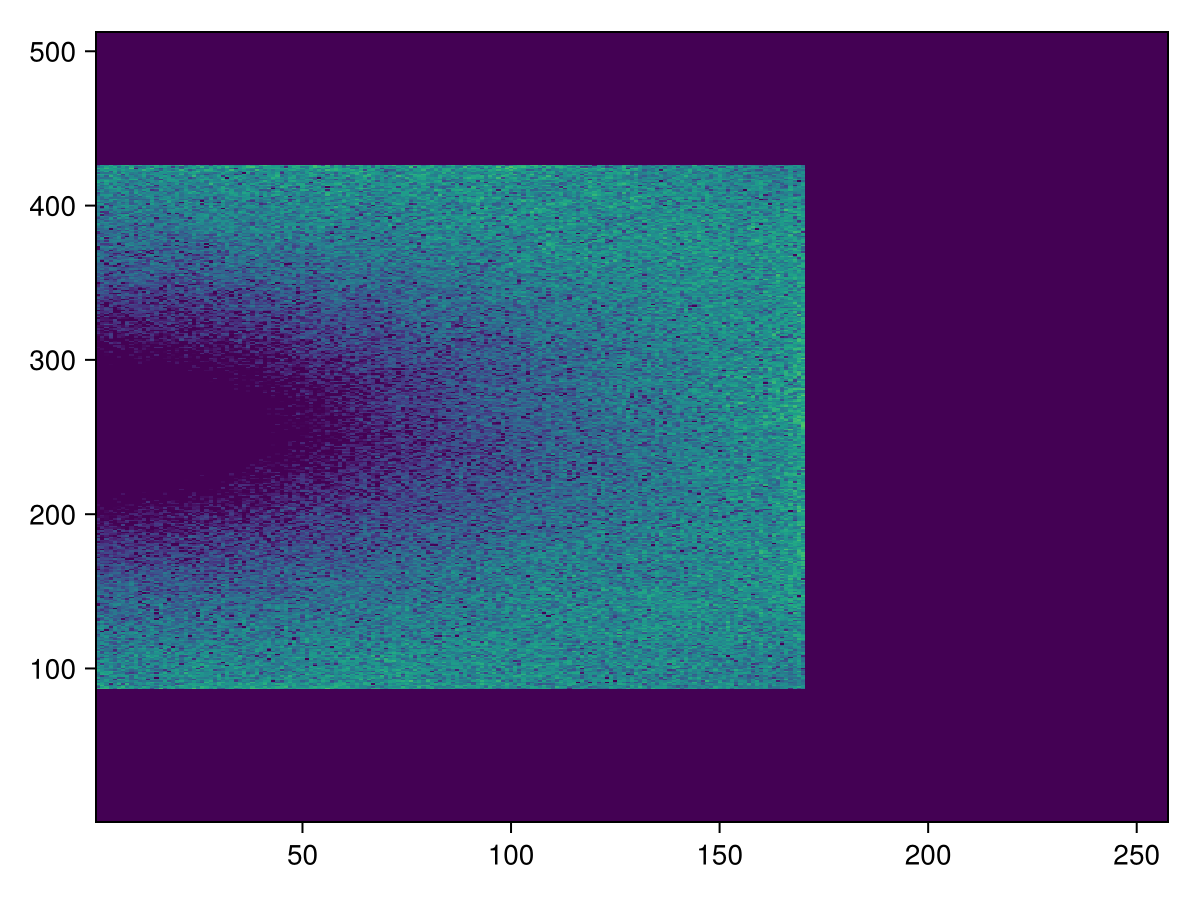

In [64]:
D = -ν * grid.Krsq.^(nν)
heatmap(fftshift(log.(abs.(conj(qh[:,:,1]) .* D .* qh[:,:,1])), 2), colorrange=(-2, 10))

In [255]:
@.  Cg2*conj(ηh)* ηh

257×512 Matrix{ComplexF32}:
 5.47335f5-0.015625im     1.88535f7+0.0im          …  1.94031f7+0.0im
 4.04377f7+0.0im          3.08313f7+1.0im             2.23912f7+0.0im
  8.0061f7-2.0im          7.56946f6-0.125im           8.25725f6+0.0im
 3.46606f6+0.0im          1.41058f7+0.0im             4.62892f6+0.0im
   18400.7+0.0im          1.07795f6-0.0625im          2.61916f6+0.0im
 1.29698f5+0.0im            35541.1+0.000244141im  …  1.44722f5-0.00390625im
   97455.6-0.000976562im    48330.5-0.000488281im       30340.6+0.000976562im
   25854.9+0.0im            24050.3+0.000976562im       4114.87+0.0im
   20069.3+0.0im            499.177+0.0im               13641.5+0.000488281im
   34688.7+0.0im            20096.9+0.0im               26193.7+0.0im
   6016.44-6.10352f-5im     882.978+0.0im          …    6695.43+0.000244141im
   11550.0+0.0im            354.881+0.0im               1203.11+6.10352f-5im
   1615.34+0.0im             6860.1+0.000244141im       5180.87-6.10352f-5im
          ⋮      

In [257]:
@. conj(uh)*uh + conj(vh)*vh

257×512 Matrix{ComplexF32}:
    3332.9+0.0im  2.77009f7+0.0im  …  1.60776f7+0.0im  2.13876f7+0.0im
  4.9716f6+0.0im  1.05521f7+0.0im     2.91236f7+0.0im  4.92364f6+0.0im
 5.91978f7+0.0im  1.00867f7+0.0im     4.05895f7+0.0im  1.30358f7+0.0im
 1.60401f6+0.0im  5.13274f7+0.0im      2.5985f7+0.0im  6.03579f6+0.0im
  6.0704f6+0.0im  7.48957f6+0.0im     3.11153f6+0.0im   1.9178f7+0.0im
  438548.0+0.0im  6.23618f6+0.0im  …  1.24791f6+0.0im  6.18376f5+0.0im
 7.41883f5+0.0im  7.04898f5+0.0im     7.00771f5+0.0im  2.22768f6+0.0im
  3.2403f5+0.0im  1.03762f6+0.0im     2.53454f5+0.0im  4.38392f5+0.0im
   36545.9+0.0im    20906.8+0.0im       56667.5+0.0im  2.85987f5+0.0im
   78137.9+0.0im    5093.15+0.0im       37968.7+0.0im    7992.74+0.0im
   4322.27+0.0im    31348.2+0.0im  …    6321.12+0.0im    13406.1+0.0im
   21785.9+0.0im    14726.3+0.0im       16462.0+0.0im    20589.7+0.0im
   11353.7+0.0im    28856.8+0.0im       12768.2+0.0im    31307.8+0.0im
          ⋮                        ⋱           ⋮ 

In [264]:
conj(ηh) .* ηh

257×512 Matrix{ComplexF32}:
 1.80937f6+0.0im  6.23255f7+0.0im  …  5.58155f7+0.0im  6.41426f7+0.0im
 1.33678f8+0.0im  1.01922f8+0.0im     9.02145f7+0.0im  7.40204f7+0.0im
 2.64664f8+0.0im   2.5023f7+0.0im     7.44174f7+0.0im  2.72967f7+0.0im
 1.14581f7+0.0im  4.66309f7+0.0im     2.18367f7+0.0im  1.53022f7+0.0im
   60828.9+0.0im  3.56346f6+0.0im       38563.9+0.0im  8.65838f6+0.0im
  428753.0+0.0im  1.17491f5+0.0im  …    59930.6+0.0im  4.78421f5+0.0im
 3.22167f5+0.0im   1.5977f5+0.0im     7.78282f5+0.0im  1.00299f5+0.0im
   85470.9+0.0im    79505.0+0.0im     2.61334f5+0.0im    13602.9+0.0im
   66344.6+0.0im    1650.17+0.0im     1.34953f5+0.0im    45096.0+0.0im
 1.14673f5+0.0im    66436.1+0.0im       3043.78+0.0im    86590.8+0.0im
   19889.1+0.0im    2918.93+0.0im  …    66405.4+0.0im    22133.7+0.0im
   38181.7+0.0im    1173.16+0.0im       31627.2+0.0im    3977.23+0.0im
   5339.97+0.0im    22678.0+0.0im       7546.92+0.0im    17126.9+0.0im
          ⋮                        ⋱           ⋮ 

In [270]:
Cg2 * (conj(ηh) .* ηh)

257×512 Matrix{ComplexF32}:
 5.47335f5+0.0im  1.88535f7+0.0im  …  1.68842f7+0.0im  1.94031f7+0.0im
 4.04377f7+0.0im  3.08313f7+0.0im     2.72899f7+0.0im  2.23912f7+0.0im
  8.0061f7+0.0im  7.56946f6+0.0im     2.25113f7+0.0im  8.25725f6+0.0im
 3.46606f6+0.0im  1.41058f7+0.0im     6.60559f6+0.0im  4.62892f6+0.0im
   18400.7+0.0im  1.07795f6+0.0im       11665.6+0.0im  2.61916f6+0.0im
 1.29698f5+0.0im    35541.1+0.0im  …    18129.0+0.0im  1.44722f5+0.0im
   97455.6+0.0im    48330.5+0.0im      2.3543f5+0.0im    30340.6+0.0im
   25854.9+0.0im    24050.3+0.0im       79053.5+0.0im    4114.87+0.0im
   20069.3+0.0im    499.177+0.0im       40823.4+0.0im    13641.5+0.0im
   34688.7+0.0im    20096.9+0.0im       920.744+0.0im    26193.7+0.0im
   6016.44+0.0im    882.978+0.0im  …    20087.6+0.0im    6695.43+0.0im
   11550.0+0.0im    354.881+0.0im       9567.24+0.0im    1203.11+0.0im
   1615.34+0.0im     6860.1+0.0im       2282.94+0.0im    5180.87+0.0im
          ⋮                        ⋱           ⋮ 